# Expand the dataset by classifying using Mobilenetv2

## 2024-07-01

In [1]:
import cv2
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
tf.random.set_seed(42)
keras.backend.clear_session()

2024-07-01 23:19:22.171259: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 23:19:22.185789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 23:19:22.206321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 23:19:22.206343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 23:19:22.219274: I tensorflow/core/platform/cpu_feature_gua

2.16.2


In [4]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_5000"

In [5]:
# from sklearn.preprocessing import LabelEncoder

# X = []
# y = []

# fnames = [fnames for fnames in os.walk(path_in)][1:]

# for class_dir, _, file_name_list in fnames:
#     lbl = class_dir.split("/")[7] # hordercoded labels here, they depend on the path
#     for f in file_name_list:
#         img = cv2.imread(os.path.join(class_dir, f), cv2.IMREAD_GRAYSCALE)
#         X.append(img)
#         y.append(lbl)

# X = rescale(X) # Run rescale layers before

# le = LabelEncoder()
# y = le.fit_transform(y)

# X.shape, y.shape

In [2]:
from keras import layers

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.1,
    subset="both",
    data_format="channels_last",
    verbose=True,
)


rescale = tf.keras.Sequential([layers.Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)


def prepare(ds, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

2024-07-01 23:18:55.548062: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 23:18:55.562496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 23:18:55.583072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 23:18:55.583096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 23:18:55.595980: I tensorflow/core/platform/cpu_feature_gua

NameError: name 'tf' is not defined

In [7]:
class_names = test_ds.class_names

In [8]:
train_ds = prepare(train_ds, augment=True)
test_ds = prepare(test_ds)

2024-07-01 17:46:24.013926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


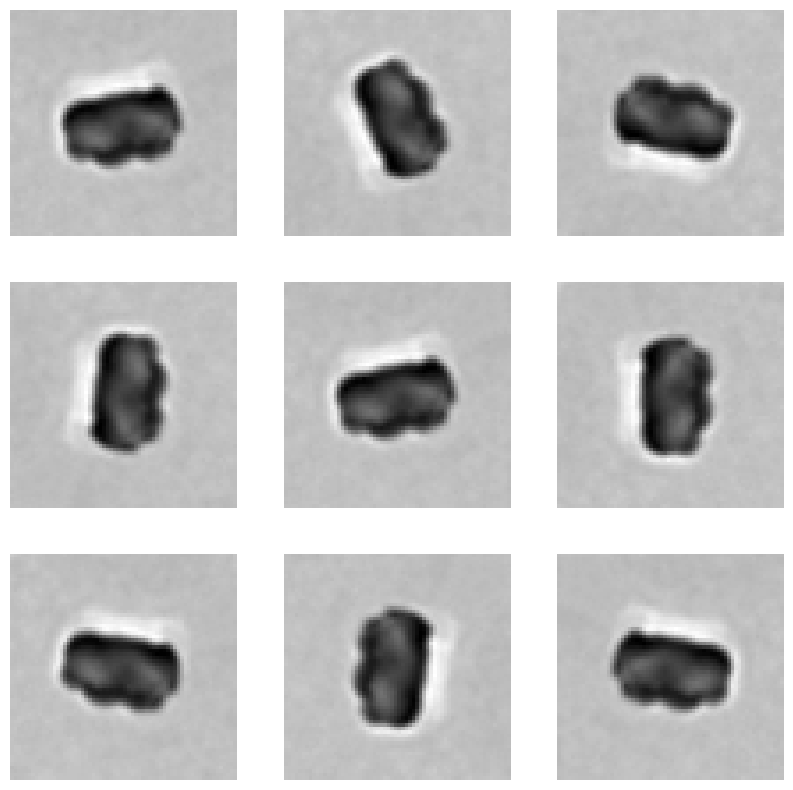

In [9]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        rescale_image = rescale(tf.expand_dims(first_image, 0))
        augmented_image = data_augmentation(rescale_image)
        plt.imshow(augmented_image[0] / 255, cmap="grey")
        plt.axis("off")

In [10]:
# Verify shapes
for data, label in train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

Train data shape: (32, 64, 64, 1), label shape: (32,)


2024-07-01 17:46:24.316949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
EPOCHS = 200

In [12]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, verbose=0, mode="min", restore_best_weights=True
)


def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [13]:
# model = keras.applications.MobileNetV2(
#     input_shape=(64, 64, 1),
#     alpha=1.0,
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     pooling="avg",
#     classes=5,
#     classifier_activation="softmax",
# )

# model.compile(
#     optimizer="nadam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"],
# )

In [ ]:
mobile_net = keras.models.load_model(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v01.keras"
)
mobile_net.summary()

Performance of the model trained on imagestream and citpyx only on citpyx data

In [15]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    fig, ax = plt.subplots(figsize=(8, 8))
    # class_names
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

In [17]:
y_pred_list = []

y_pred = mobile_net.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

y_test = []
for images, lbls in test_ds:
    y_test.extend(lbls.numpy())

I0000 00:00:1719848787.704575 3955753 service.cc:145] XLA service 0x56324dc8d190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719848787.704617 3955753 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-01 17:46:27.741004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 17:46:28.071810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

I0000 00:00:1719848789.782081 3955753 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step


2024-07-01 17:46:32.591799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
accuracy = balanced_accuracy_score(y_test, y_pred)
f1_score_model = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
scores = {
    "test_balanced_accuracy": accuracy,
    "test_f1_weighted": f1_score_model,
    "test_precision_weighted": precision,
}
scores = pd.DataFrame(scores, index=[0])
scores

,test_balanced_accuracy,test_f1_weighted,test_precision_weighted
0,0.402128,0.510771,0.510389


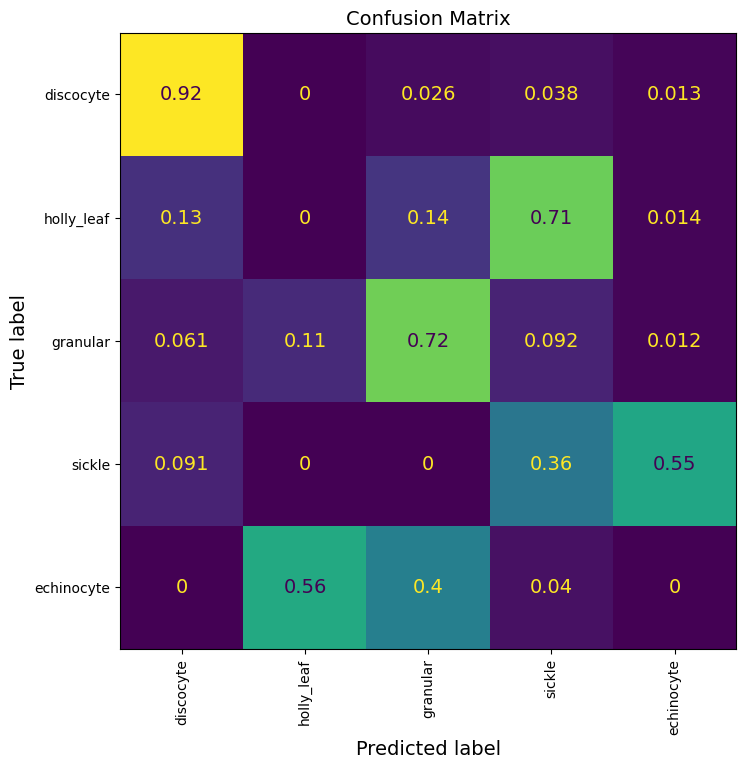

In [19]:
get_confusion_matrix(y_test, y_pred, class_names)

Retrain the model's top layers

In [20]:
for i, layer in enumerate(mobile_net.layers):
    print(i, layer.name, layer.trainable)

0 input_layer True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu

In [21]:
# for layer in mobile_net.layers:
#     layer.trainable = False
# # or if we want to set the first 20 layers of the network to be non-trainable
# for layer in mobile_net.layers[:20]:
#     layer.trainable = False
# for layer in mobile_net.layers[20:]:
#     layer.trainable = True

In [22]:
# with tf.device("GPU:0"):
#     history = mobile_net.fit(
#         train_ds,
#         validation_data=test_ds,
#         callbacks=[earlystopper, lr_scheduler],
#         epochs=EPOCHS,
#     )

Partial retraining did not imporve the model, will try adding extra layers

In [23]:
mobile_net = tf.keras.Model(
    inputs=mobile_net.inputs, outputs=mobile_net.layers[-2].output
)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    ReLU,
)
from tensorflow.keras.regularizers import l2


model = Sequential()

model.add(mobile_net)

mobile_net.trainable = False

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(
    Dense(5, activation="softmax", kernel_regularizer=l2(0.01))
)  # Final layer with softmax activation

In [25]:
model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [26]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.4701 - loss: 23.1079 - val_accuracy: 0.6156 - val_loss: 5.9383 - learning_rate: 0.0010
Epoch 2/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5273 - loss: 4.4592 - val_accuracy: 0.6828 - val_loss: 1.8337 - learning_rate: 0.0010
Epoch 3/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5410 - loss: 1.7688 - val_accuracy: 0.5995 - val_loss: 1.3090 - learning_rate: 0.0010
Epoch 4/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5460 - loss: 1.3578 - val_accuracy: 0.5296 - val_loss: 1.1673 - learning_rate: 0.0010
Epoch 5/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5239 - loss: 1.3010 - val_accuracy: 0.6156 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 6/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5343 - loss: 1.2860 - val_accuracy: 0.5995 - val_loss: 1.5752 - learning_rate: 0.0010
Epoch 7/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5247 - loss:

In [27]:
y_pred_list = []

y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

y_test = []
for images, lbls in test_ds:
    y_test.extend(lbls.numpy())

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step


2024-07-01 17:47:41.655959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
accuracy = balanced_accuracy_score(y_test, y_pred)
f1_score_model = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
scores = {
    "test_balanced_accuracy": accuracy,
    "test_f1_weighted": f1_score_model,
    "test_precision_weighted": precision,
}
scores = pd.DataFrame(scores, index=[0])
scores

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,test_balanced_accuracy,test_f1_weighted,test_precision_weighted
0,0.457465,0.600838,0.644175


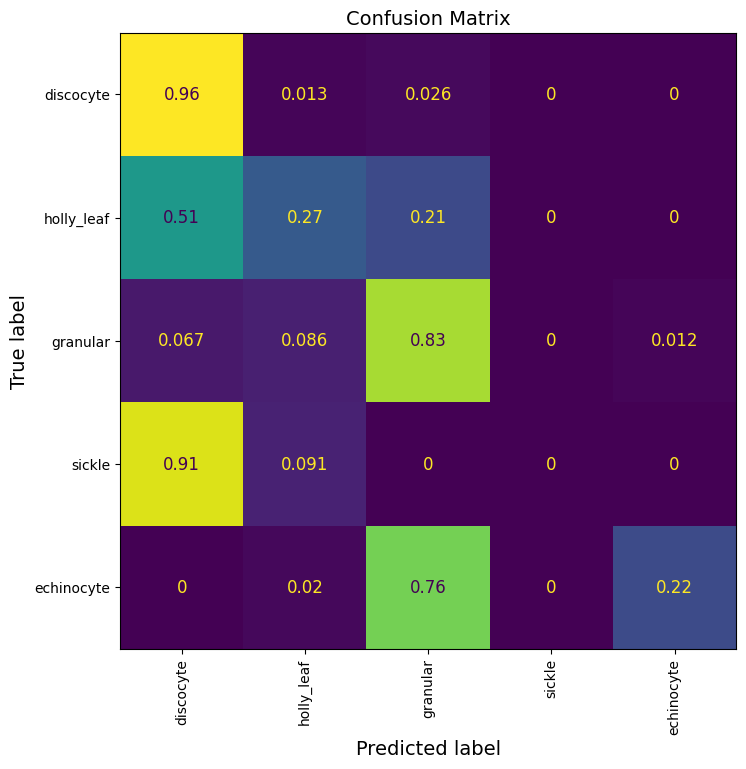

In [29]:
get_confusion_matrix(y_test, y_pred, class_names)

In [30]:
def extract_labels_and_class_names(ds, class_names):
    labels = []
    for _, lbls in ds:
        labels.extend(lbls.numpy())
    labels = np.array(labels)
    class_names_for_labels = [class_names[label] for label in labels]
    return labels, class_names_for_labels


# Extract labels and corresponding class names from the dataset
labels, class_names_for_labels = extract_labels_and_class_names(test_ds, class_names)
print("Labels:", labels)
print("Class Names for Labels:", class_names_for_labels)

Labels: [4 2 2 4 4 2 2 1 2 1 2 0 4 0 4 2 2 2 2 2 2 2 2 2 0 0 2 2 1 2 1 2 2 1 0 2 1
 0 2 2 1 2 0 4 4 2 0 2 2 1 2 3 2 2 2 1 0 2 4 4 0 2 0 2 1 2 2 0 0 2 2 0 4 2
 0 0 0 4 2 2 2 0 2 2 2 0 2 2 4 1 0 1 2 2 0 2 0 2 2 2 0 0 1 2 2 4 1 2 4 2 2
 2 0 0 1 3 1 2 4 0 4 2 2 2 0 4 2 3 2 2 2 1 2 0 2 2 2 1 2 2 2 1 3 1 2 1 2 0
 4 2 1 4 4 4 2 4 0 2 4 4 4 2 1 2 0 0 0 1 2 1 2 2 1 0 1 4 2 2 4 1 2 1 2 0 2
 1 1 2 1 4 2 2 3 2 4 1 2 2 2 1 1 1 2 1 0 0 3 0 1 4 0 1 3 2 0 1 2 2 4 2 1 0
 4 2 4 0 2 2 1 1 0 4 2 2 0 2 2 3 2 2 2 1 2 1 0 4 0 1 2 1 2 2 1 2 3 0 2 2 1
 1 0 0 4 4 4 0 2 1 0 0 1 2 1 0 0 1 1 0 2 2 2 3 2 0 0 0 0 2 2 2 0 2 0 2 2 1
 0 0 2 0 2 2 0 2 0 2 2 1 4 1 4 2 4 2 2 1 0 4 2 0 4 0 1 2 2 1 4 2 2 2 4 2 0
 2 1 4 0 2 1 1 2 4 0 1 2 2 2 4 2 0 3 2 0 0 1 2 2 2 1 1 2 0 0 2 2 2 4 2 1 4
 1 2]
Class Names for Labels: ['echinocyte', 'granular', 'granular', 'echinocyte', 'echinocyte', 'granular', 'granular', 'holly_leaf', 'granular', 'holly_leaf', 'granular', 'discocyte', 'echinocyte', 'discocyte', 'echinocyte', 'granular', 'gr

2024-07-01 17:47:42.062259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
from collections import Counter

Counter(class_names_for_labels).keys()

dict_keys(['echinocyte', 'granular', 'holly_leaf', 'discocyte', 'sickle'])

In [32]:
Counter(class_names_for_labels).values()

dict_values([50, 163, 70, 78, 11])

Predicting new cytopix images

In [37]:
dataset_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262"
fnames = [dataset_path + "/" + image for image in os.listdir(dataset_path)]

In [96]:
X = []
for name in fnames[5001:10000]:
    img = cv2.imread(os.path.join(dataset_path, name), cv2.IMREAD_GRAYSCALE)
    X.append(img)

In [97]:
len(X)

4999

In [98]:
X = tf.expand_dims(X, axis=-1, name=None)
X = rescale(X)

In [100]:
X.shape

TensorShape([4999, 64, 64, 1])

In [101]:
y_pred = model.predict(X)
y_pred = y_pred.argmax(axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [102]:
y_pred

array([0, 2, 2, ..., 2, 1, 2])

In [42]:
class_names

['discocyte', 'holly_leaf', 'granular', 'sickle', 'echinocyte']

In [103]:
def integers_to_labels(integer_list, class_names):
    labels = [class_names[idx] for idx in integer_list]
    return labels

In [104]:
y_pred = integers_to_labels(y_pred, class_names)

In [113]:
path_out = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_10k"

In [114]:
# my_list = ["discocyte","echinocyte", "granular", "holly_leaf", "sickle"]
# root_path = path_out

# for items in my_list:
#     path = os.path.join(root_path, items)
#     os.mkdir(path)

In [110]:
for name, prediction in zip(fnames, y_pred):
    file_name = name.split("/")[-1]
    print(os.path.join(dataset_path, name))
    print(os.path.join(path_out, prediction, file_name))

    img = cv2.imread(os.path.join(dataset_path, name), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(os.path.join(path_out, prediction, file_name), img)

/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262/0000198e5271d6317b88554bb42519a3.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_10k/discocyte/0000198e5271d6317b88554bb42519a3.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262/000040960984c457d2da9089d736faad.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_10k/granular/000040960984c457d2da9089d736faad.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262/00005043df14ff947e40dd8f3f3795db.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_10k/granular/00005043df14ff947e40dd8f3f3795db.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262/0006362b11698a3f9180de79cb73c8bc.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_10k/granular/0006362b11698a3f9180de79cb73c8bc.png
/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262/0006bfb90c2737ddff3218b4f320ab